In [252]:
!source /home/jackg/dev/lab4_ws/install/setup.bash && echo "ROS2 environment sourced."

import rosbag2_py
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message
import numpy as np
import matplotlib.pyplot as plt
from transforms3d.euler import quat2euler
from scipy.optimize import minimize

from sensor_msgs.msg import MagneticField
from imu_msg.msg import IMUmsg  # Import your custom IMU message type

ROS2 environment sourced.


In [253]:
!pwd
def read_rosbag(bag_path):
    reader = rosbag2_py.SequentialReader()
    reader.open(
        rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3'),
        rosbag2_py.ConverterOptions(input_serialization_format='cdr', output_serialization_format='cdr')
    )
    topic_types = reader.get_all_topics_and_types()
    type_map = {topic_types[i].name: topic_types[i].type for i in range(len(topic_types))}
    data = []
    while reader.has_next():
        (topic, msg, t) = reader.read_next()
        msg_type = get_message(type_map[topic])
        msg_deserialized = deserialize_message(msg, msg_type)
        data.append((topic, msg_deserialized, t))
    return data

raw_circle_data = read_rosbag("/home/jackg/dev/lab4_ws/data/data_circle2")
raw_driving_data = read_rosbag("/home/jackg/dev/lab4_ws/data/data_drive")


/home/jackg/dev/lab4_ws/data


[INFO] [1730256057.463102580] [rosbag2_storage]: Opened database '/home/jackg/dev/lab4_ws/data/data_circle2/data_circle2_0.db3' for READ_ONLY.
[INFO] [1730256057.815239232] [rosbag2_storage]: Opened database '/home/jackg/dev/lab4_ws/data/data_drive/data_drive_0.db3' for READ_ONLY.


In [254]:
def get_topic_data(data):
    
    # GPS lists
    gps_times = []
    utm_easting = []
    utm_northing = []
    alt = []

    # IMU lists
    imu_times = []
    accel_x, accel_y, accel_z = [], [], []
    gyro_x, gyro_y, gyro_z = [], [], []
    mag_x, mag_y, mag_z = [], [], []
    roll, pitch, yaw = [], [], []

    # Extract data from the bag
    for topic, msg, t in data:
        if topic == '/imu':
            imu_times.append(msg.header.stamp)
            # Access IMU data
            imu_data = msg.imu
            accel_x.append(imu_data.linear_acceleration.x)
            accel_y.append(imu_data.linear_acceleration.y)
            accel_z.append(imu_data.linear_acceleration.z)
            gyro_x.append(imu_data.angular_velocity.x)
            gyro_y.append(imu_data.angular_velocity.y)
            gyro_z.append(imu_data.angular_velocity.z)
            # Access magnetometer data
            mag_data = msg.mag_field
            mag_x.append(mag_data.magnetic_field.x)
            mag_y.append(mag_data.magnetic_field.y)
            mag_z.append(mag_data.magnetic_field.z)
            # Convert quaternion to Euler angles
            q = imu_data.orientation
            euler = quat2euler([q.w, q.x, q.y, q.z])
            roll.append(euler[0])
            pitch.append(euler[1])
            yaw.append(euler[2])
        elif topic == '/gps':
            gps_times.append(msg.header.stamp)
            gps_data = msg
            utm_easting.append(gps_data.utm_easting)
            utm_northing.append(gps_data.utm_northing)
            alt.append(gps_data.altitude)

    return  gps_times, utm_easting, utm_northing, alt, \
            imu_times, accel_x, accel_y, accel_z, \
            gyro_x, gyro_y, gyro_z, \
            mag_x, mag_y, mag_z, \
            roll, pitch, yaw
            

gps_times, utm_easting, utm_northing, alt, \
imu_times, accel_x, accel_y, accel_z, \
gyro_x, gyro_y, gyro_z, \
mag_x, mag_y, mag_z, \
roll, pitch, yaw = get_topic_data(raw_circle_data)

def create_time_series_from_arrays(secs, nanosecs):
    # Get initial time
    t0_sec = secs[0]
    t0_nsec = nanosecs[0]
    
    # Create time series relative to start time
    times = []
    for sec, nsec in zip(secs, nanosecs):
        dt = (sec - t0_sec) + (nsec - t0_nsec) * 1e-9
        times.append(dt)
        
    return times


Hard Iron Offsets: (5.608e-05, 1.592e-05, 4.671e-06)
Soft Iron Matrix:
 [[ 1.04617445  0.04655167 -0.49505528]
 [ 0.04655167  1.08104077 -0.17456137]
 [-0.49505528 -0.17456137  9.39560668]]
Soft Iron Matrix:
 [[ 1.04617445  0.04655167 -0.49505528]
 [ 0.04655167  1.08104077 -0.17456137]
 [-0.49505528 -0.17456137  9.39560668]]


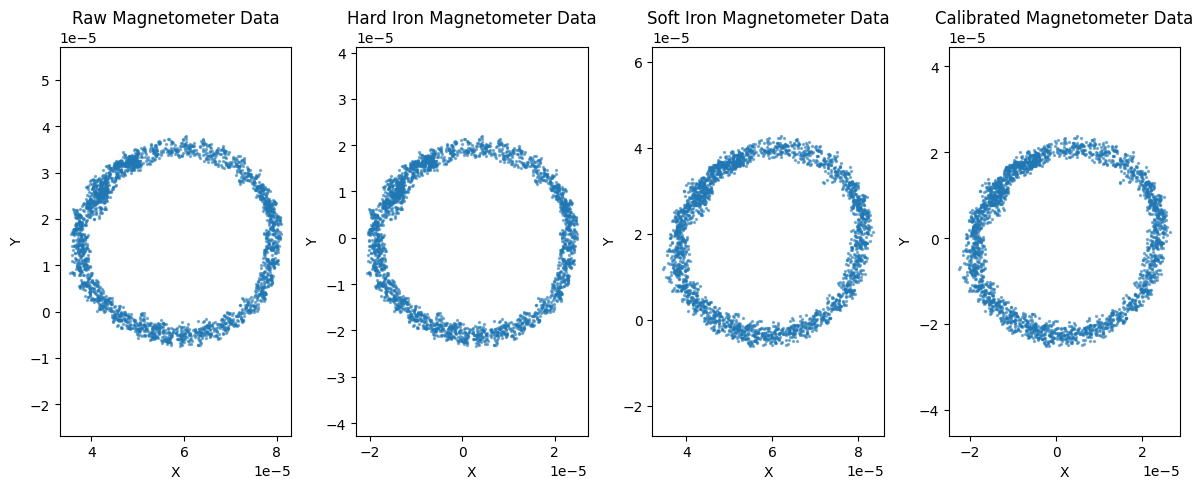

In [255]:
def hard_iron_cal(x, y, z):
    # calculate the mean of each axis (hard iron offsets)
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    z_mean = np.mean(z)
    
    # subtract each axis by the mean to remove hard iron errors
    x_corrected = x - x_mean
    y_corrected = y - y_mean
    z_corrected = z - z_mean
    
    print(f'Hard Iron Offsets: ({x_mean:.3e}, {y_mean:.3e}, {z_mean:.3e})')
    
    return x_corrected, y_corrected, z_corrected, (x_mean, y_mean, z_mean)

def soft_iron_cal(x, y, z):
    # Normalize the data
    data = np.column_stack((x, y, z))
    
    # Compute covariance matrix of normalized data
    cov_data = np.cov(data, rowvar=False)
    
    # Eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eig(cov_data)
    
    # Normalize eigenvalues relative to largest eigenvalue
    scaling_matrix = np.diag(1.0 / np.sqrt(eigenvalues/np.max(eigenvalues)))
    
    # Combined transformation matrix
    transformation_matrix = eigenvectors @ scaling_matrix @ eigenvectors.T
    
    # Apply the transformation
    data_cal = data @ transformation_matrix
    
    print("Soft Iron Matrix:\n", transformation_matrix)
    
    return data_cal[:,0], data_cal[:,1], data_cal[:,2], transformation_matrix

def calibrate_with_circle_data(x, y, z, scale_factor=1.0):

    mag_x = np.array(x) * scale_factor
    mag_y = np.array(y) * scale_factor
    mag_z = np.array(z) * scale_factor
    
    # Get hard iron calibration and offsets
    hard_x, hard_y, hard_z, hard_iron_offsets = hard_iron_cal(mag_x, mag_y, mag_z)

    # Get soft iron calibration and transformation matrix
    soft_x, soft_y, soft_z, soft_iron_matrix = soft_iron_cal(mag_x, mag_y, mag_z)
    
    # Get soft iron calibration and transformation matrix
    cal_x, cal_y, cal_z, soft_iron_matrix = soft_iron_cal(hard_x, hard_y, hard_z)
    
    # Plot before and after
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 5))
    
    ax1.scatter(mag_x, mag_y, s=2, alpha=0.5)
    ax1.set_title('Raw Magnetometer Data')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.axis('equal')

    ax2.scatter(hard_x, hard_y, s=2, alpha=0.5)
    ax2.set_title('Hard Iron Magnetometer Data')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.axis('equal')

    ax3.scatter(soft_x, soft_y, s=2, alpha=0.5)
    ax3.set_title('Soft Iron Magnetometer Data')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.axis('equal')
    
    ax4.scatter(cal_x, cal_y, s=2, alpha=0.5)
    ax4.set_title('Calibrated Magnetometer Data')
    ax4.set_xlabel('X')
    ax4.set_ylabel('Y')
    ax4.axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    return hard_iron_offsets, soft_iron_matrix

hard_iron_offsets, soft_iron_matrix = calibrate_with_circle_data(
    mag_x, mag_y, mag_z, 
)

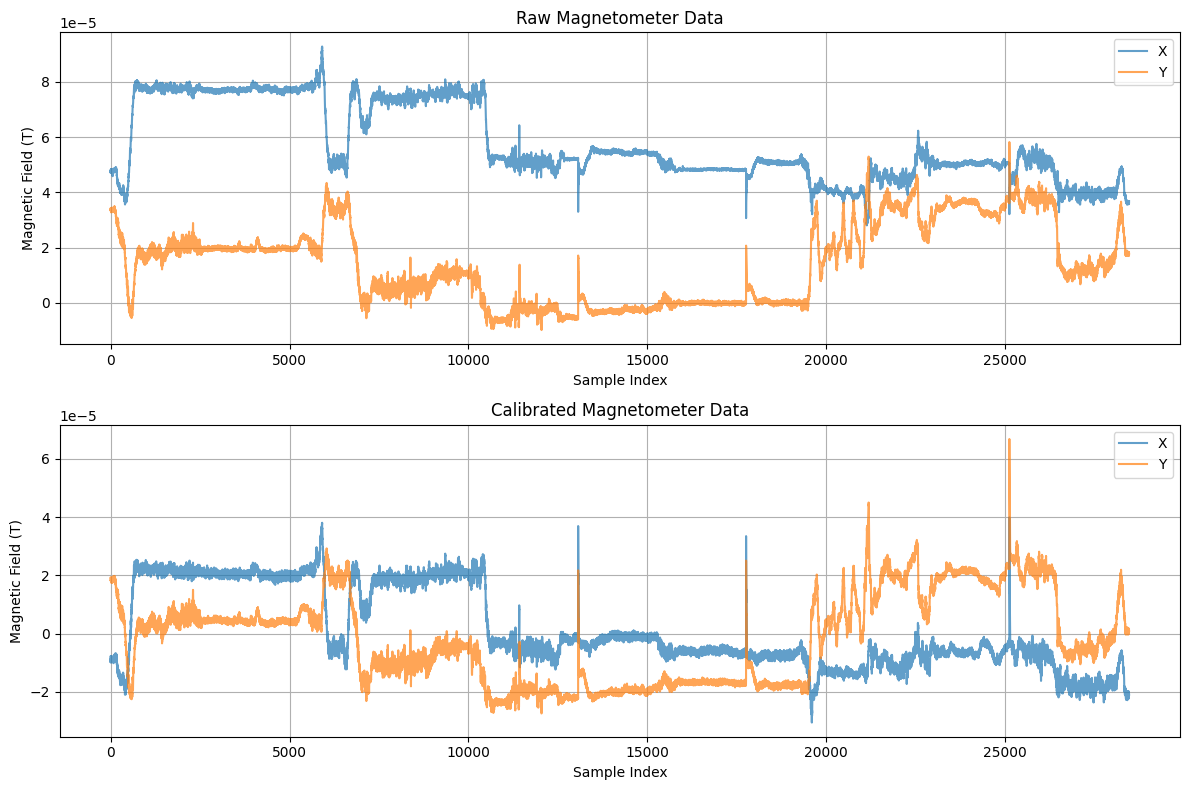

In [256]:
gps_times, utm_easting, utm_northing, alt, \
imu_times, accel_x, accel_y, accel_z, \
gyro_x, gyro_y, gyro_z, \
mag_x, mag_y, mag_z, \
roll, pitch, yaw = get_topic_data(raw_driving_data)

imu_times_sec = create_time_series_from_arrays([t.sec for t in imu_times], [t.nanosec for t in imu_times])

def apply_calibration(x, y, z, hard_iron_offsets, soft_iron_matrix):
    # Apply hard iron correction
    x_hard = x - hard_iron_offsets[0]
    y_hard = y - hard_iron_offsets[1]
    z_hard = z - hard_iron_offsets[2]
    
    # Apply soft iron correction
    data = np.vstack((x_hard, y_hard, z_hard)).T
    data_cal = data @ soft_iron_matrix.T
    
    # Extract calibrated values
    x_cal, y_cal, z_cal = data_cal.T
    return x_cal, y_cal, z_cal

cal_x, cal_y, cal_z = apply_calibration(
    mag_x, mag_y, mag_z,
    hard_iron_offsets, soft_iron_matrix
)

# Create plots to compare raw and calibrated magnetometer data over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot raw magnetometer data
ax1.plot(mag_x, label='X', alpha=0.7)
ax1.plot(mag_y, label='Y', alpha=0.7)
ax1.set_title('Raw Magnetometer Data')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Magnetic Field (T)')
ax1.legend()
ax1.grid(True)

# Plot calibrated magnetometer data
ax2.plot(cal_x, label='X', alpha=0.7)
ax2.plot(cal_y, label='Y', alpha=0.7)
ax2.set_title('Calibrated Magnetometer Data')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Magnetic Field (T)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

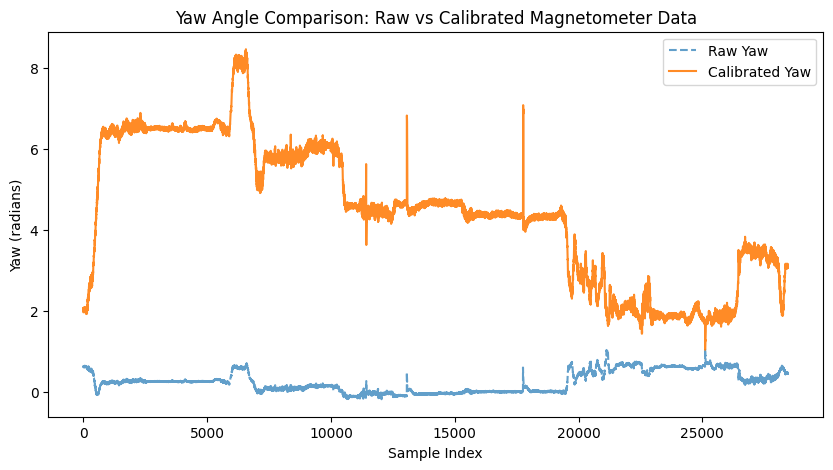

In [257]:
def calc_yaw(x, y):
    yaw = np.arctan2(y, x)
    yaw_unwrapped = np.unwrap(yaw)
    return yaw_unwrapped

def plot_yaw(mag_x, mag_y, cal_x, cal_y):
    raw_yaw = calc_yaw(mag_x, mag_y)
    cal_yaw = calc_yaw(cal_x, cal_y)
    
    # Plot the yaw angles for comparison
    plt.figure(figsize=(10, 5))
    plt.plot(raw_yaw, label='Raw Yaw', linestyle='--', alpha=0.7)
    plt.plot(cal_yaw, label='Calibrated Yaw', linestyle='-', alpha=0.9)
    plt.title('Yaw Angle Comparison: Raw vs Calibrated Magnetometer Data')
    plt.xlabel('Sample Index')
    plt.ylabel('Yaw (radians)')
    plt.legend()
    plt.show()

calculated_yaw = calc_yaw(cal_x, cal_y)
plot_yaw(mag_x, mag_y, cal_x, cal_y)

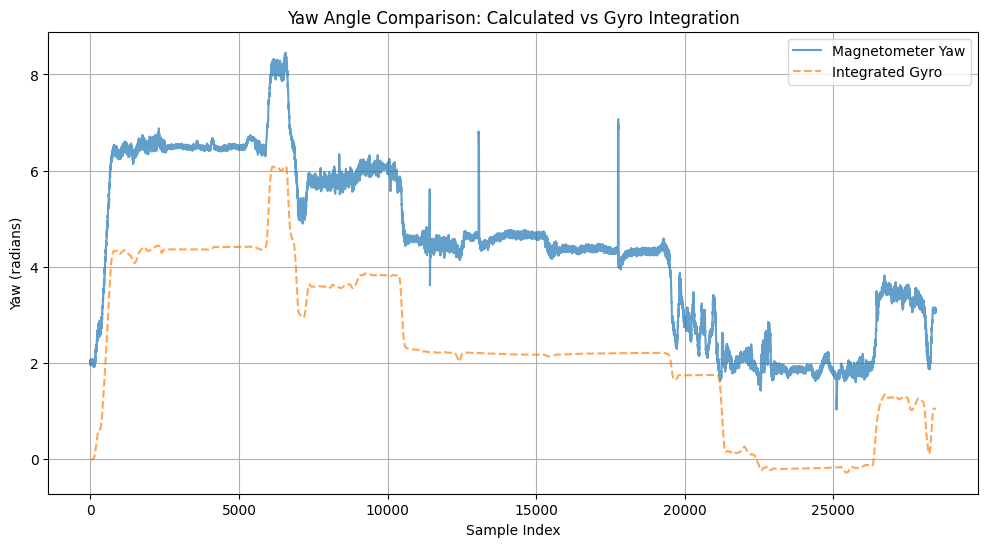

In [258]:
import scipy

def integrate_gyro(gyro_z, dt):

    # Use cumulative trapezoid integration
    yaw_gyro = scipy.integrate.cumulative_trapezoid(gyro_z, dx=dt, initial=0)
    
    return -yaw_gyro

def plot_yaw_comparison(calculated_yaw, gyro_z, dt):
    # Integrate gyro data to get yaw angle
    gyro_yaw = integrate_gyro(gyro_z, dt)
    
    # Plot the yaw angles for comparison
    plt.figure(figsize=(12, 6))
    plt.plot(calculated_yaw, label='Magnetometer Yaw', alpha=0.7)
    plt.plot(gyro_yaw, label='Integrated Gyro', alpha=0.7, linestyle='--')
    plt.ylabel('Yaw (radians)')
    plt.xlabel('Sample Index')
    plt.legend()
    plt.grid(True)
    plt.title('Yaw Angle Comparison: Calculated vs Gyro Integration')

dt = 1/40

plot_yaw_comparison(calculated_yaw, gyro_z, dt)

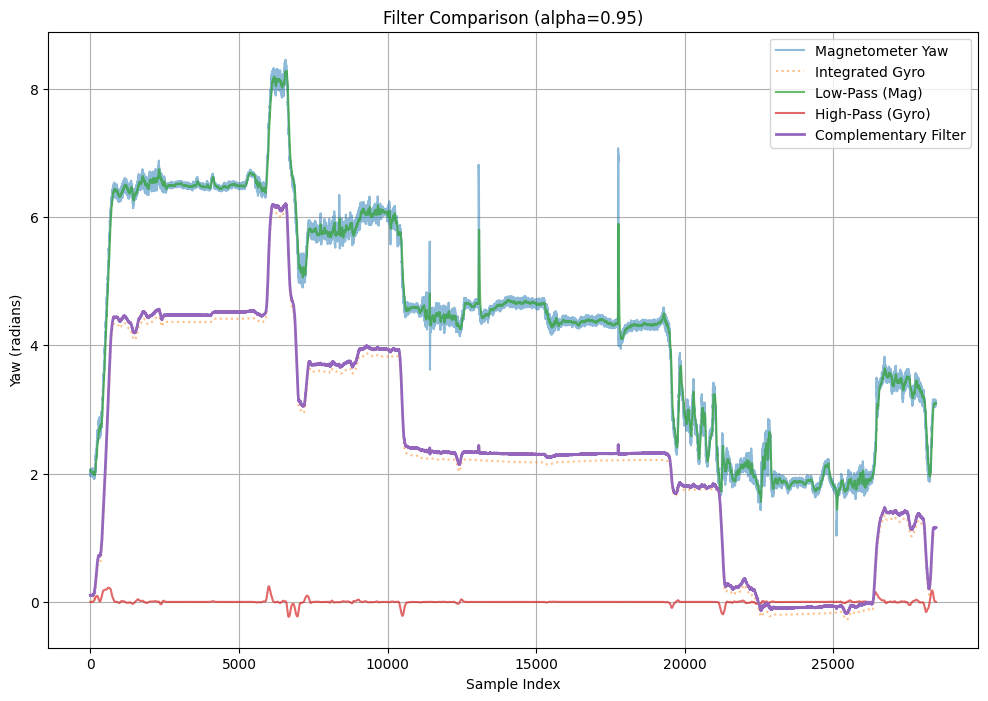

In [259]:
def simple_filters(mag_yaw, gyro_z, dt, alpha=0.90):
    # Get integrated gyro
    gyro_yaw = integrate_gyro(gyro_z, dt)
   
    # Simple low-pass filter on magnetometer
    lp_filter = np.zeros_like(mag_yaw)
    lp_filter[0] = mag_yaw[0]  
    for i in range(1, len(mag_yaw)):
        lp_filter[i] = alpha * lp_filter[i-1] + (1 - alpha) * mag_yaw[i]
   
    # Simple high-pass filter on gyro
    hp_filter = np.zeros_like(gyro_yaw)
    hp_filter[0] = gyro_yaw[0]  
    for i in range(1, len(gyro_yaw)):
        hp_filter[i] = alpha * (hp_filter[i-1] + gyro_yaw[i] - gyro_yaw[i-1])
   
    # Simple complementary filter
    comp_filter = alpha * gyro_yaw + (1 - alpha) * mag_yaw
    return lp_filter, hp_filter, comp_filter


def plot_filter_evaluation(mag_yaw, gyro_z, dt, alpha):
    # Get filter results
    lp_filter, hp_filter, comp_filter = simple_filters(mag_yaw, gyro_z, dt, alpha)
    
    plt.figure(figsize=(12, 8))
    
    # Plot all signals
    plt.plot(mag_yaw, label='Magnetometer Yaw', alpha=0.5)
    plt.plot(integrate_gyro(gyro_z, dt), label='Integrated Gyro', alpha=0.5, linestyle=':')
    plt.plot(lp_filter, label='Low-Pass (Mag)', alpha=0.7)
    plt.plot(hp_filter, label='High-Pass (Gyro)', alpha=0.7)
    plt.plot(comp_filter, label='Complementary Filter', linewidth=2)
    
    plt.ylabel('Yaw (radians)')
    plt.xlabel('Sample Index')
    plt.legend()
    plt.grid(True)
    plt.title(f'Filter Comparison (alpha={alpha})')

plot_filter_evaluation(calculated_yaw, gyro_z, dt, .95)

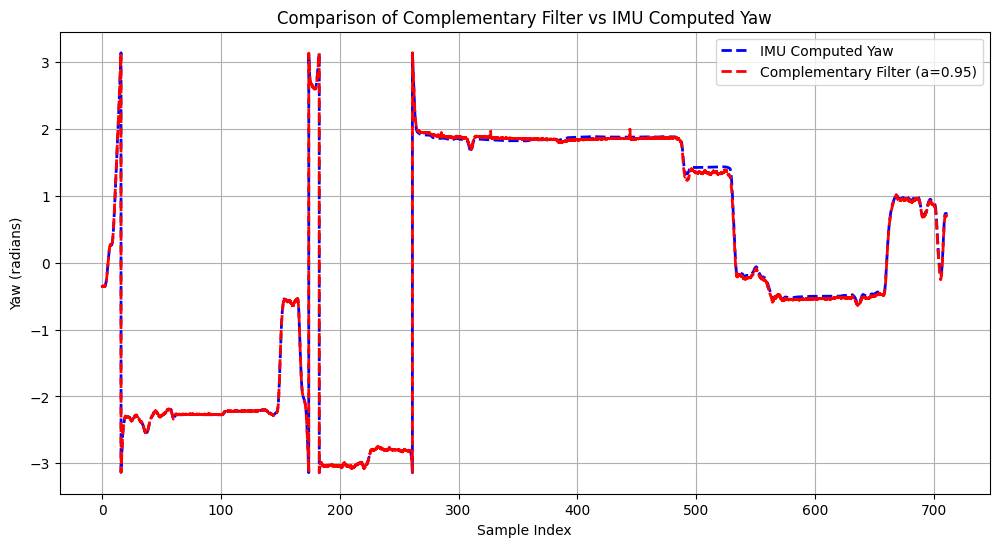

In [260]:
def compare_yaw_estimates(time, mag_yaw, gyro_yaw, imu_yaw, alpha=0.95):

    # Apply complementary filter
    lp_filter, hp_filter, comp_filter = simple_filters(mag_yaw, gyro_z, dt, alpha)
    imu_yaw = -np.array(imu_yaw)   # Invert IMU yaw to match
    
    # Align initial reference frames
    initial_offset = comp_filter[0] - imu_yaw[0]
    aligned_comp_filter = comp_filter - initial_offset
    
    # Ensure angles are wrapped to same range (e.g., -π to π)
    aligned_comp_filter = np.unwrap(aligned_comp_filter)
    imu_yaw_unwrapped = np.unwrap(imu_yaw)
    
    # Normalize to same range after unwrapping
    aligned_comp_filter = np.mod(aligned_comp_filter + np.pi, 2*np.pi) - np.pi
    imu_yaw_normalized = np.mod(imu_yaw_unwrapped + np.pi, 2*np.pi) - np.pi
    
    plt.figure(figsize=(12, 6))
    plt.plot(time, imu_yaw_normalized, 'b--', label='IMU Computed Yaw', linewidth=2)
    plt.plot(time, aligned_comp_filter, 'r--', label=f'Complementary Filter (a={alpha})', linewidth=2)
    
    
    plt.grid(True)
    plt.xlabel('Sample Index')
    plt.ylabel('Yaw (radians)')
    plt.title('Comparison of Complementary Filter vs IMU Computed Yaw')
    plt.legend()

    return comp_filter

# Example usage:
gyro_yaw = integrate_gyro(gyro_z, dt)
comp_filter = compare_yaw_estimates(imu_times_sec, calculated_yaw, gyro_yaw, yaw)

In [261]:
def read_rosbag(bag_path):
    reader = rosbag2_py.SequentialReader()
    reader.open(
        rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3'),
        rosbag2_py.ConverterOptions(input_serialization_format='cdr', output_serialization_format='cdr')
    )
    topic_types = reader.get_all_topics_and_types()
    type_map = {topic_types[i].name: topic_types[i].type for i in range(len(topic_types))}
    data = []
    while reader.has_next():
        (topic, msg, t) = reader.read_next()
        msg_type = get_message(type_map[topic])
        msg_deserialized = deserialize_message(msg, msg_type)
        data.append((topic, msg_deserialized, t))
    return data

raw_circle_data = read_rosbag("/home/jackg/dev/lab4_ws/data/data_circle2")
raw_driving_data = read_rosbag("/home/jackg/dev/lab4_ws/data/data_drive")

def get_topic_data(data):
    
    # GPS lists
    gps_times = []
    utm_easting = []
    utm_northing = []
    alt = []

    # IMU lists
    imu_times = []
    accel_x, accel_y, accel_z = [], [], []
    gyro_x, gyro_y, gyro_z = [], [], []
    mag_x, mag_y, mag_z = [], [], []
    roll, pitch, yaw = [], [], []

    # Extract data from the bag
    for topic, msg, t in data:
        if topic == '/imu':
            imu_times.append(msg.header.stamp)
            # Access IMU data
            imu_data = msg.imu
            accel_x.append(imu_data.linear_acceleration.x)
            accel_y.append(imu_data.linear_acceleration.y)
            accel_z.append(imu_data.linear_acceleration.z)
            gyro_x.append(imu_data.angular_velocity.x)
            gyro_y.append(imu_data.angular_velocity.y)
            gyro_z.append(imu_data.angular_velocity.z)
            # Access magnetometer data
            mag_data = msg.mag_field
            mag_x.append(mag_data.magnetic_field.x)
            mag_y.append(mag_data.magnetic_field.y)
            mag_z.append(mag_data.magnetic_field.z)
            # Convert quaternion to Euler angles
            q = imu_data.orientation
            euler = quat2euler([q.w, q.x, q.y, q.z])
            roll.append(euler[0])
            pitch.append(euler[1])
            yaw.append(euler[2])
        elif topic == '/gps':
            gps_times.append(msg.header.stamp)
            gps_data = msg
            utm_easting.append(gps_data.utm_easting)
            utm_northing.append(gps_data.utm_northing)
            alt.append(gps_data.altitude)

    return  gps_times, utm_easting, utm_northing, alt, \
            imu_times, accel_x, accel_y, accel_z, \
            gyro_x, gyro_y, gyro_z, \
            mag_x, mag_y, mag_z, \
            roll, pitch, yaw
            

gps_times, utm_easting, utm_northing, alt, \
imu_times, accel_x, accel_y, accel_z, \
gyro_x, gyro_y, gyro_z, \
mag_x, mag_y, mag_z, \
roll, pitch, yaw = get_topic_data(raw_driving_data)
print(imu_times[0], imu_times[-1])

def create_time_series_from_arrays(secs, nanosecs):
    # Get initial time
    t0_sec = secs[0]
    t0_nsec = nanosecs[0]
    
    # Create time series relative to start time
    times = []
    for sec, nsec in zip(secs, nanosecs):
        dt = (sec - t0_sec) + (nsec - t0_nsec) * 1e-9
        times.append(dt)
        
    return times

imu_times_sec = create_time_series_from_arrays([t.sec for t in imu_times], [t.nanosec for t in imu_times])
gps_times_sec = create_time_series_from_arrays([t.sec for t in gps_times], [t.nanosec for t in gps_times])
print(imu_times_sec[0], imu_times_sec[-1])

[INFO] [1730256063.965450087] [rosbag2_storage]: Opened database '/home/jackg/dev/lab4_ws/data/data_circle2/data_circle2_0.db3' for READ_ONLY.
[INFO] [1730256064.295565506] [rosbag2_storage]: Opened database '/home/jackg/dev/lab4_ws/data/data_drive/data_drive_0.db3' for READ_ONLY.


builtin_interfaces.msg.Time(sec=1729716814, nanosec=571229515) builtin_interfaces.msg.Time(sec=1729717526, nanosec=22399092)
0.0 711.451169577


711
710
710


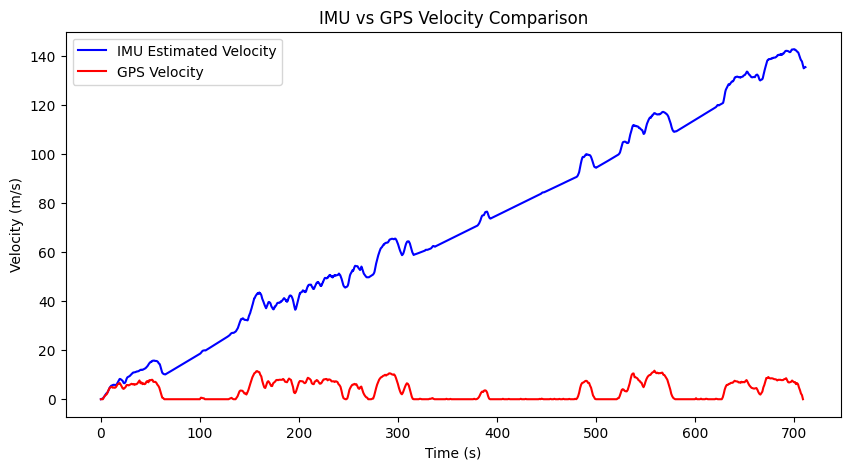

In [262]:
def calculate_gps_velocity(utm_easting, utm_northing, times_sec):
    # Calculate time differences between consecutive points
    dt = np.diff(times_sec)
    
    # Calculate position differences
    d_easting = np.diff(utm_easting)
    d_northing = np.diff(utm_northing)

    # Calculate velocity magnitude
    velocity = np.sqrt(d_easting**2 + d_northing**2) / dt
    
    # The resulting velocity array will be one element shorter than the input arrays
    return velocity

print(len(gps_times_sec))
print(len(utm_easting[:-1]))

gps_velocity = calculate_gps_velocity(utm_easting, utm_northing, gps_times_sec)
print(len(gps_velocity))

from scipy.integrate import cumulative_trapezoid

def integrate_acceleration(acceleration, dt):
    velocity = cumulative_trapezoid(acceleration, dx=dt, initial=0)
    return velocity

dt = 1 / 40  # IMU sampling rate is 40 Hz

# Integrate acceleration to get velocity
integrated_velocity_x = integrate_acceleration(accel_x, dt)
integrated_velocity_y = integrate_acceleration(accel_y, dt)

plt.figure(figsize=(10, 5))
plt.plot(imu_times_sec, integrated_velocity_x, label='IMU Estimated Velocity', color='b')
plt.plot(gps_times_sec[:-1], gps_velocity, label='GPS Velocity', color='r')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.title('IMU vs GPS Velocity Comparison')
plt.show()

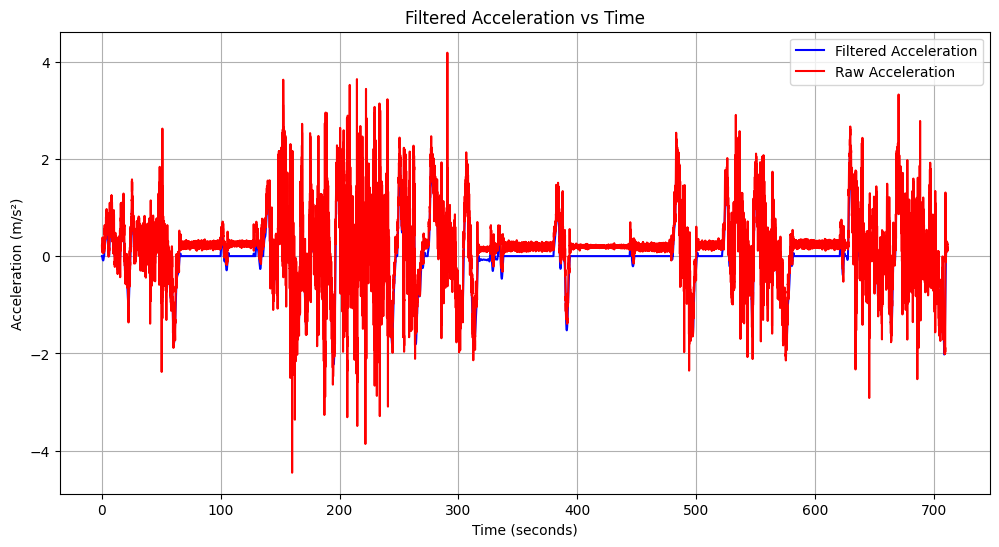

In [270]:
import numpy as np
from scipy.signal import butter, filtfilt

def remove_bias(accel_data, window_size=100):
    initial_bias = np.mean(accel_data[:window_size])
    return accel_data - initial_bias
def apply_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)
def threshold_small_values(data, threshold=0.05):
    data_clean = data.copy()
    data_clean[np.abs(data_clean) < threshold] = 0
    return data_clean
def process_acceleration(accel_data, fs=40, cutoff=0.5, bias_window=100, threshold=0.05):
    accel_debiased = remove_bias(accel_data, bias_window)

    accel_filtered = apply_lowpass_filter(accel_debiased, cutoff, fs)
   
    accel_cleaned = threshold_small_values(accel_filtered, threshold)
   
    return accel_cleaned

cleaned_accel_x = process_acceleration(accel_x)
cleaned_accel_y = process_acceleration(accel_y)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(imu_times_sec, cleaned_accel_x, 'b-', label='Filtered Acceleration')
plt.plot(imu_times_sec, accel_x, 'r-', label='Raw Acceleration')
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration (m/s²)')
plt.title('Filtered Acceleration vs Time')
plt.grid(True)
plt.legend()
plt.show()


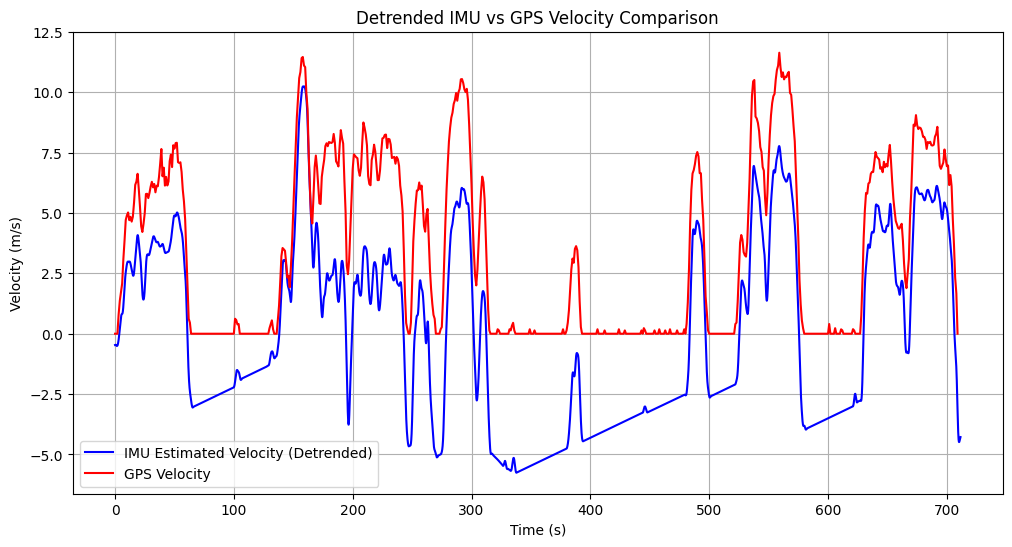

In [269]:
from scipy import stats


def detrend_velocity(time_list, velocity_list):

    time = np.array(time_list)
    velocity = np.array(velocity_list)
    
    # Calculate line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(time, velocity)
    line_of_best_fit = slope * time + intercept
    
    # Remove trend
    detrended_velocity = velocity - line_of_best_fit
    
    
    return detrended_velocity

dt = 1/40  

integrated_velocity_x = integrate_acceleration(cleaned_accel_x, dt)
integrated_velocity_y = integrate_acceleration(cleaned_accel_y, dt)

# Make sure all inputs are numpy arrays
imu_times_sec = np.array(imu_times_sec)
integrated_velocity_x = np.array(integrated_velocity_x)
integrated_velocity_y = np.array(integrated_velocity_y)
gps_times_sec = np.array(gps_times_sec)
gps_velocity = np.array(gps_velocity)

# Detrend X velocity
detrended_velocity_x = detrend_velocity(imu_times_sec, integrated_velocity_x)

# Detrend Y velocity
detrended_velocity_y = detrend_velocity(imu_times_sec, integrated_velocity_y)

# Compare with GPS velocity
plt.figure(figsize=(12, 6))
plt.plot(imu_times_sec, detrended_velocity_x, label='IMU Estimated Velocity (Detrended)', color='b')
plt.plot(gps_times_sec[:-1], gps_velocity, label='GPS Velocity', color='r')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Detrended IMU vs GPS Velocity Comparison')
plt.legend()
plt.grid(True)
plt.show()

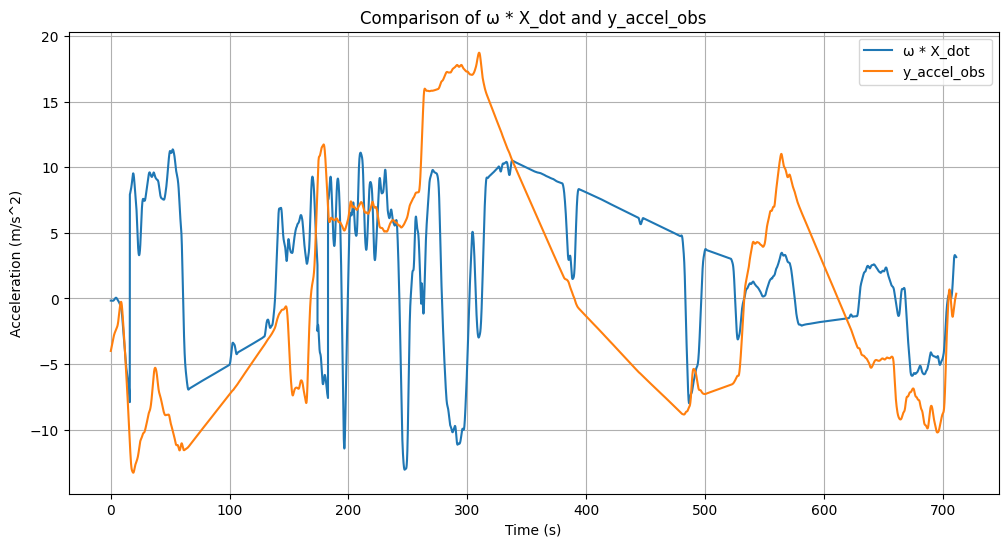

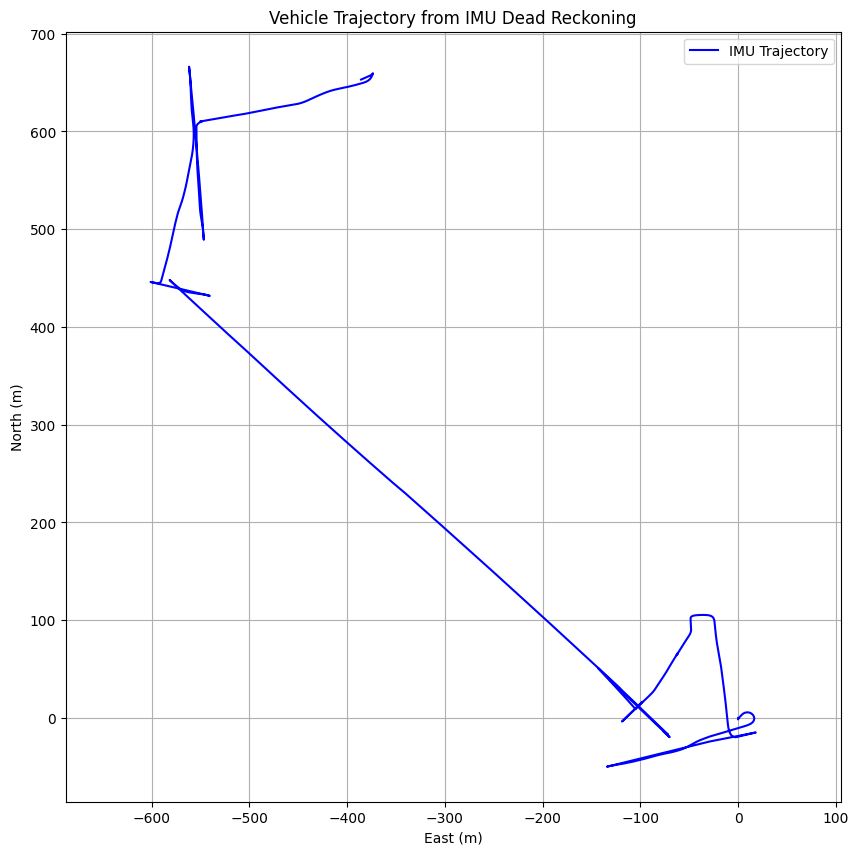

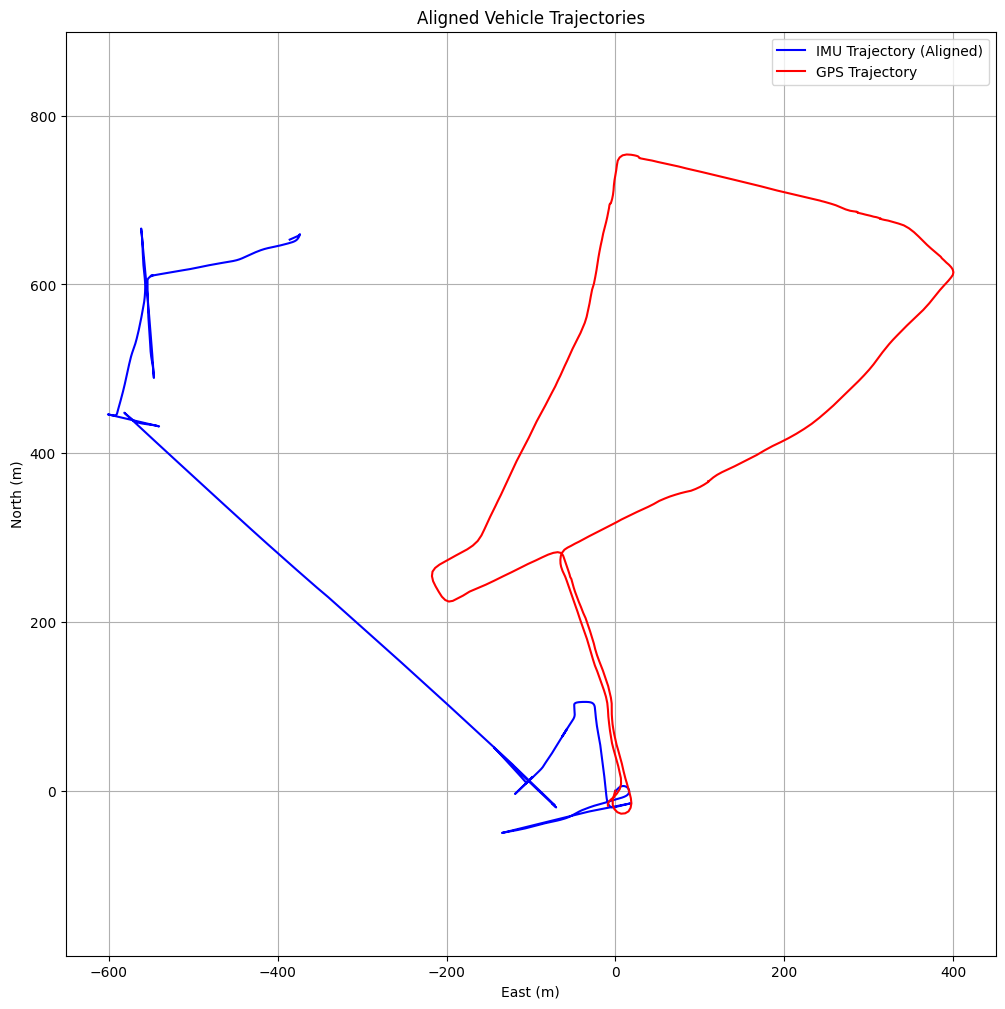

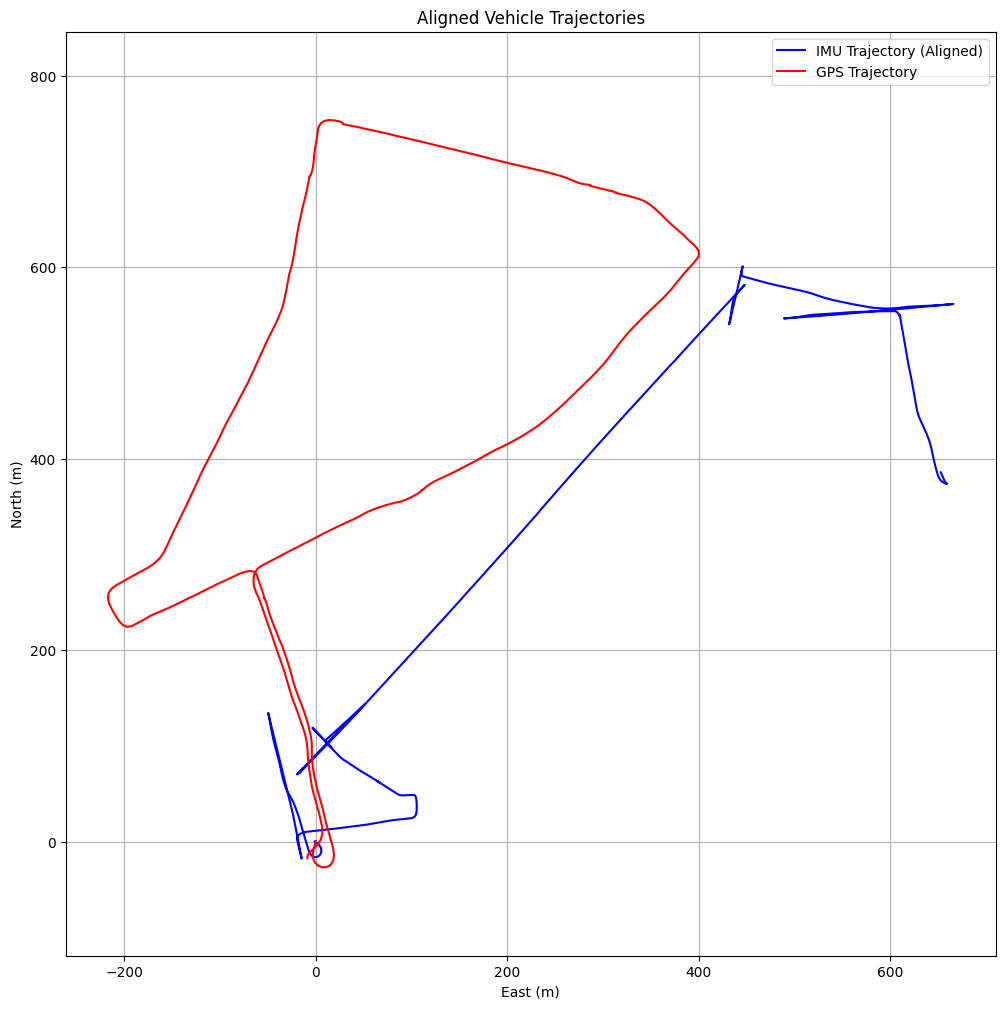

In [265]:
def dead_reckoning_analysis(time_list, forward_velocity_list, omega_list, y_accel_obs_list, heading_list):
    # Convert all inputs to numpy arrays
    time = np.array(time_list)
    forward_velocity = np.array(forward_velocity_list)
    omega = np.array(omega_list)
    y_accel_obs = np.array(y_accel_obs_list)
    heading = np.array(heading_list)
    
    # Compute omega * X_dot
    omega_X_dot = omega * forward_velocity
    
    # Plot omega * X_dot vs y_accel_obs
    plt.figure(figsize=(12, 6))
    plt.plot(time, omega_X_dot, label='ω * X_dot')
    plt.plot(time, y_accel_obs, label='y_accel_obs')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s^2)')
    plt.title('Comparison of ω * X_dot and y_accel_obs')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Convert forward velocity to East-North components using heading
    ve = forward_velocity * np.sin(heading)  # East velocity
    vn = forward_velocity * np.cos(heading)  # North velocity
    
    # Integrate velocities to get position
    xe = cumulative_trapezoid(ve, time, initial=0)  # East position
    xn = cumulative_trapezoid(vn, time, initial=0)  # North position
    
    # Plot trajectory
    plt.figure(figsize=(10, 10))
    plt.plot(xe, xn, 'b-', label='IMU Trajectory')
    plt.xlabel('East (m)')
    plt.ylabel('North (m)')
    plt.title('Vehicle Trajectory from IMU Dead Reckoning')
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return xe, xn, ve, vn

def align_trajectories(imu_e_list, imu_n_list, gps_e_list, gps_n_list, rotation_angle=270):
    # Convert all inputs to numpy arrays
    xe = np.array(imu_e_list)
    xn = np.array(imu_n_list)
    gps_e = np.array(gps_e_list)
    gps_n = np.array(gps_n_list)
    
    # Translate both trajectories to start at (0,0)
    xe_aligned = xe - xe[0]
    xn_aligned = xn - xn[0]
    gps_e_aligned = gps_e - gps_e[0]
    gps_n_aligned = gps_n - gps_n[0]
    
    # Rotate IMU trajectory
    angle_rad = np.deg2rad(rotation_angle)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])
    
    # Apply rotation to translated IMU trajectory
    points = np.vstack((xe_aligned, xn_aligned))
    rotated_points = rotation_matrix @ points
    xe_rotated = rotated_points[0]
    xn_rotated = rotated_points[1]
    
    # Plot aligned and rotated trajectories
    plt.figure(figsize=(12, 12))
    plt.plot(xe_rotated, xn_rotated, 'b-', label='IMU Trajectory (Aligned)')
    plt.plot(gps_e_aligned, gps_n_aligned, 'r-', label='GPS Trajectory')
    plt.xlabel('East (m)')
    plt.ylabel('North (m)')
    plt.title('Aligned Vehicle Trajectories')
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return xe_rotated, xn_rotated

# Perform dead reckoning analysis
xe, xn, ve, vn = dead_reckoning_analysis(
    imu_times_sec,
    detrended_velocity_x, 
    yaw, 
    detrended_velocity_y, 
    comp_filter
)

# Align trajectories and get scaling factor
xe_scaled, xn_scaled = align_trajectories(xe, xn, utm_easting, utm_northing, rotation_angle=0)
xe_scaled, xn_scaled = align_trajectories(xe, xn, utm_easting, utm_northing)
